# Data Modification
This script modifies the data in a couple of ways

### Handle cancelled flights
This script assigns delay values to cancelled flights. It does so in different ways:
* Delayed flights get a delay of 12h
* Delayed flights get a delay of 24h
* Delayed flights get as their delay the time until the next flight. If it does not exist, it will get assigned a delay of 12h.

### Aggregate delay columns into 'Total_Delay'
As the customer does not care about the origin of the delay but rather the total delay, it is not important to predict the delay originating from different sources as a whole.

### Remove unrelated columns/obsolete columns
From a qualitative point of view, it is obvious that some variables contain no predictive power. These columns will be removed. Besides that, some columns are linear combinations of others and therefore do not contain any more information. These will also be removed.

### Reformat datetimes
The dates are represented as strings. We will convert them to datetimes. Moreover, columns containing the day of week and month will be added. We intent to use these instead of the data for predictions. A column of an indicator variable that indicates whether the day is a hollyday will also be added.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import re
import timezonefinder, pytz
import math

airlines = pd.read_csv('Data\\airlines.csv')
airports = pd.read_csv('Data\\airports.csv')
past_data = pd.read_csv('Data\\historic_data.csv')
august_data = pd.read_csv('Data\\future_data.csv')

In [2]:
# Display original data
past_data.head()

USE_ALL_DATA = True
WRITE_DATA = True

if USE_ALL_DATA:
    df = past_data
else:
    # Randomly sample a small data set from past_data to work on for testing.
    df = past_data.sample(n=300, replace=False)
    df.reset_index(inplace=True, drop=True)

## Create a Total_Delay column

In [3]:
DelayCol = [col for col in df.columns.values if "DELAY" in col]
df['TOTAL_DELAY'] = df[DelayCol].sum(axis=1, skipna=True)

df.head()

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_ARRIVAL,ARRIVAL_TIME,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,...,WHEELS_ON,TAXI_IN,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,TOTAL_DELAY
0,2019-03-01 00:01:00,00:02:00,01:37:00,01:20:00,UA,1238,N812UA,DEN,BIL,1.0,...,117.0,3.0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,2019-03-01 00:01:00,00:29:00,01:33:00,01:52:00,EV,6134,N14171,ORD,BNA,28.0,...,144.0,8.0,0,NaN,0.0,0.0,19.0,0.0,0.0,47.0
2,2019-03-01 00:01:00,NaN,01:53:00,NaN,EV,4682,N15910,ORD,BHM,NaN,...,NaN,NaN,1,B,NaN,NaN,NaN,NaN,NaN,0.0
3,2019-03-01 00:02:00,23:59:00,03:04:00,02:56:00,UA,1550,N822UA,ORD,BTV,-3.0,...,252.0,4.0,0,NaN,NaN,NaN,NaN,NaN,NaN,-3.0
4,2019-03-01 00:02:00,00:36:00,03:22:00,03:30:00,UA,1502,N33262,ORD,BOS,34.0,...,326.0,4.0,0,NaN,NaN,NaN,NaN,NaN,NaN,34.0


## Drop unnecessary columns
We drop the columns that have no predictive power from a qualitative point of view. Furthermore, as our goal is to predict the delay of flights in the future, we cannot use variables that can only be recorded during or after the flight. These columns are also dropped.

More specifically
* The columns __DEPARTURE_TIME__, __ARRIVAL_TIME__, all ___DELAY__ columns, __TAXI_IN__, __TAXI_OUT__, __WHEELS_ON__, __WHEELS_OF__, __AIR_TIME__, __ELAPSED_TIME__, __CANCELLATION_REASON__ and __CANCELLED__ are dropped as these variables are not available to make predictions for flight that are yet to take place. As a consequence, these variables are not included in the _August_data_ data set. As we will still need the __CANCELLED__ column when setting delays for cancelled flights, we don't drop it yet.
* __FLIGHT_NUMBER__ and __TAIL_NUMBER__ are dropped as they do not hold any predictive value from a qualitative point of view.
* Maybe we'll drop __SCHEDULED_ARRIVAL__ as it is closely related to __SCHEDULED_TIME__ but does not take timezones into account.

In [4]:
df.columns.values

array(['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'SCHEDULED_ARRIVAL',
       'ARRIVAL_TIME', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER',
       'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DEPARTURE_DELAY',
       'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME',
       'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'CANCELLED',
       'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY',
       'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY',
       'TOTAL_DELAY'], dtype=object)

In [5]:
df.drop(columns=['DEPARTURE_TIME', 'ARRIVAL_TIME', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'DEPARTURE_DELAY', 'TAXI_OUT', 'TAXI_IN',
                 'WHEELS_OFF', 'WHEELS_ON', 'AIR_TIME', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 
                 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'ELAPSED_TIME'], inplace=True)
df.head()

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_TIME,DISTANCE,CANCELLED,TOTAL_DELAY
0,2019-03-01 00:01:00,01:37:00,UA,DEN,BIL,96.0,455,0,1.0
1,2019-03-01 00:01:00,01:33:00,EV,ORD,BNA,92.0,409,0,47.0
2,2019-03-01 00:01:00,01:53:00,EV,ORD,BHM,112.0,584,1,0.0
3,2019-03-01 00:02:00,03:04:00,UA,ORD,BTV,122.0,763,0,-3.0
4,2019-03-01 00:02:00,03:22:00,UA,ORD,BOS,140.0,867,0,34.0


## Reformat datetimes
We convert the __SCHEDULED_DEPARTURE__ column to a datetime format.

We also try to recreate the column __SCHEDULED_TIME__. It was noticed earlier in _tryout.ipynb_ that this column is not just the difference of the columns __SCHEDULED_DEPARTURE__ and __SCHEDULED_ARRIVAL__. A reason for this could have been time zone differences. Trying to recompute this column taking time zones into account we get better results, though it is still not equal to __SCHEDULED_TIME__. Some observations in the data just do not make sense. For example, this is a flight:

7	2019-05-27 17:00:00	18:15:00	WN	LAS	PHX	75.0	255	3.0	15.0

But this does not make sense, as there is a 1 hour time difference between Phoenix and Las Vegas. Therefore, if the plane takes of at 17:00:00 in Vegas and lands at 18:15:00 in Phoenix, then the plane would have flown for only 15 minutes. Even fighter jets don't go that fast.

Since the column __SCHEDULED_TIME__ is not in the _august_data_ set we could drop it and just use the manually computed times in order to be consistent (we would need to compute them for the _august_data_ anyway).

In [6]:
# Convert string values that indicate dates and times to datetime objects
toConvert = ['SCHEDULED_DEPARTURE']
for col in toConvert:
    df[col] = pd.to_datetime(df[col])

In [7]:
df.head()

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_TIME,DISTANCE,CANCELLED,TOTAL_DELAY
0,2019-03-01 00:01:00,01:37:00,UA,DEN,BIL,96.0,455,0,1.0
1,2019-03-01 00:01:00,01:33:00,EV,ORD,BNA,92.0,409,0,47.0
2,2019-03-01 00:01:00,01:53:00,EV,ORD,BHM,112.0,584,1,0.0
3,2019-03-01 00:02:00,03:04:00,UA,ORD,BTV,122.0,763,0,-3.0
4,2019-03-01 00:02:00,03:22:00,UA,ORD,BOS,140.0,867,0,34.0


In [8]:
tf = timezonefinder.TimezoneFinder()

# From the lat/long, get the tz-database-style time zone name (e.g. 'America/Vancouver') or None
timezone_str = tf.certain_timezone_at(lat=49.2827, lng=-123.1207)

if timezone_str is None:
    print("Could not determine the time zone")
else:
    # Display the current time in that time zone
    timezone = pytz.timezone(timezone_str)
    some_dt = dt.datetime.utcnow()
    print("The time in %s is %s" % (timezone_str, some_dt + timezone.utcoffset(some_dt)))

The time in America/Vancouver is 2022-03-12 03:29:15.372491


In [9]:
iteration_count = 0

def compute_scheduled_time(row, airports, verbose):
    
    # We will display an output to the log every time 100 observations have been completed if 'verbose' 
    # is selected. To this end, we define a variable that will be used for counting the number of already
    # handled observations.
    global iteration_count
    
    if verbose:
        if iteration_count % 1000 == 0:
            print("Iteration count (computing delay):", iteration_count)
        iteration_count += 1
    
    # Get time difference between airports
    tf = timezonefinder.TimezoneFinder()
    origin = row['ORIGIN_AIRPORT']
    destination = row['DESTINATION_AIRPORT']
    
    # Maybe surround this with a try-except as timezonefinder sometimes fails.
    try:
        timezone_origin = tf.certain_timezone_at(lat=float(airports[airports['IATA_CODE'] == origin]['LATITUDE']), 
                                                 lng=float(airports[airports['IATA_CODE'] == origin]['LONGITUDE']))
        timezone_dest = tf.certain_timezone_at(lat=float(airports[airports['IATA_CODE'] == destination]['LATITUDE']), 
                                                 lng=float(airports[airports['IATA_CODE'] == destination]['LONGITUDE']))

        timezone_origin = pytz.timezone(timezone_origin)
        timezone_dest = pytz.timezone(timezone_dest)
        lag = timezone_dest.utcoffset(dt.datetime.utcnow()) - timezone_origin.utcoffset(dt.datetime.utcnow())
    except:
        lag = dt.timedelta(hours=0)
    
    # Compute difference in arrival and departure time
    dep_dt = row['SCHEDULED_DEPARTURE']
    arr_time = dt.time(int(row['SCHEDULED_ARRIVAL'][0:2]), int(row['SCHEDULED_ARRIVAL'][3:5]), int(row['SCHEDULED_ARRIVAL'][6:8]))

    arr_dt = dt.datetime(dep_dt.year, dep_dt.month, dep_dt.day, arr_time.hour, arr_time.minute, arr_time.second)
    
    delta_t = arr_dt - dep_dt
    if delta_t.days < 0:
        delta_t = delta_t + dt.timedelta(hours=24)
    
    return (delta_t - lag).seconds / 60

df['ELAPSED_TIME_SELF']= df.apply(lambda x: compute_scheduled_time(x, airports, verbose=True), axis = 1)

Iteration count (computing delay): 0
Iteration count (computing delay): 1000
Iteration count (computing delay): 2000
Iteration count (computing delay): 3000
Iteration count (computing delay): 4000
Iteration count (computing delay): 5000
Iteration count (computing delay): 6000
Iteration count (computing delay): 7000
Iteration count (computing delay): 8000
Iteration count (computing delay): 9000
Iteration count (computing delay): 10000
Iteration count (computing delay): 11000
Iteration count (computing delay): 12000
Iteration count (computing delay): 13000
Iteration count (computing delay): 14000
Iteration count (computing delay): 15000
Iteration count (computing delay): 16000
Iteration count (computing delay): 17000
Iteration count (computing delay): 18000
Iteration count (computing delay): 19000
Iteration count (computing delay): 20000
Iteration count (computing delay): 21000
Iteration count (computing delay): 22000
Iteration count (computing delay): 23000
Iteration count (computing de

Iteration count (computing delay): 198000
Iteration count (computing delay): 199000
Iteration count (computing delay): 200000
Iteration count (computing delay): 201000
Iteration count (computing delay): 202000
Iteration count (computing delay): 203000
Iteration count (computing delay): 204000
Iteration count (computing delay): 205000
Iteration count (computing delay): 206000
Iteration count (computing delay): 207000
Iteration count (computing delay): 208000
Iteration count (computing delay): 209000
Iteration count (computing delay): 210000
Iteration count (computing delay): 211000
Iteration count (computing delay): 212000
Iteration count (computing delay): 213000
Iteration count (computing delay): 214000
Iteration count (computing delay): 215000
Iteration count (computing delay): 216000
Iteration count (computing delay): 217000
Iteration count (computing delay): 218000
Iteration count (computing delay): 219000
Iteration count (computing delay): 220000
Iteration count (computing delay):

Iteration count (computing delay): 394000
Iteration count (computing delay): 395000
Iteration count (computing delay): 396000
Iteration count (computing delay): 397000
Iteration count (computing delay): 398000
Iteration count (computing delay): 399000
Iteration count (computing delay): 400000
Iteration count (computing delay): 401000
Iteration count (computing delay): 402000
Iteration count (computing delay): 403000
Iteration count (computing delay): 404000
Iteration count (computing delay): 405000
Iteration count (computing delay): 406000
Iteration count (computing delay): 407000
Iteration count (computing delay): 408000
Iteration count (computing delay): 409000
Iteration count (computing delay): 410000
Iteration count (computing delay): 411000
Iteration count (computing delay): 412000
Iteration count (computing delay): 413000
Iteration count (computing delay): 414000
Iteration count (computing delay): 415000
Iteration count (computing delay): 416000
Iteration count (computing delay):

Iteration count (computing delay): 590000
Iteration count (computing delay): 591000
Iteration count (computing delay): 592000
Iteration count (computing delay): 593000
Iteration count (computing delay): 594000
Iteration count (computing delay): 595000
Iteration count (computing delay): 596000
Iteration count (computing delay): 597000
Iteration count (computing delay): 598000
Iteration count (computing delay): 599000
Iteration count (computing delay): 600000
Iteration count (computing delay): 601000
Iteration count (computing delay): 602000
Iteration count (computing delay): 603000
Iteration count (computing delay): 604000
Iteration count (computing delay): 605000
Iteration count (computing delay): 606000
Iteration count (computing delay): 607000
Iteration count (computing delay): 608000
Iteration count (computing delay): 609000
Iteration count (computing delay): 610000
Iteration count (computing delay): 611000
Iteration count (computing delay): 612000
Iteration count (computing delay):

Iteration count (computing delay): 786000
Iteration count (computing delay): 787000
Iteration count (computing delay): 788000
Iteration count (computing delay): 789000
Iteration count (computing delay): 790000
Iteration count (computing delay): 791000
Iteration count (computing delay): 792000
Iteration count (computing delay): 793000
Iteration count (computing delay): 794000
Iteration count (computing delay): 795000
Iteration count (computing delay): 796000
Iteration count (computing delay): 797000
Iteration count (computing delay): 798000
Iteration count (computing delay): 799000
Iteration count (computing delay): 800000
Iteration count (computing delay): 801000
Iteration count (computing delay): 802000
Iteration count (computing delay): 803000
Iteration count (computing delay): 804000
Iteration count (computing delay): 805000
Iteration count (computing delay): 806000
Iteration count (computing delay): 807000
Iteration count (computing delay): 808000
Iteration count (computing delay):

Iteration count (computing delay): 982000
Iteration count (computing delay): 983000
Iteration count (computing delay): 984000
Iteration count (computing delay): 985000
Iteration count (computing delay): 986000
Iteration count (computing delay): 987000
Iteration count (computing delay): 988000
Iteration count (computing delay): 989000
Iteration count (computing delay): 990000
Iteration count (computing delay): 991000
Iteration count (computing delay): 992000
Iteration count (computing delay): 993000
Iteration count (computing delay): 994000
Iteration count (computing delay): 995000
Iteration count (computing delay): 996000
Iteration count (computing delay): 997000
Iteration count (computing delay): 998000
Iteration count (computing delay): 999000
Iteration count (computing delay): 1000000
Iteration count (computing delay): 1001000
Iteration count (computing delay): 1002000
Iteration count (computing delay): 1003000
Iteration count (computing delay): 1004000
Iteration count (computing de

Iteration count (computing delay): 1173000
Iteration count (computing delay): 1174000
Iteration count (computing delay): 1175000
Iteration count (computing delay): 1176000
Iteration count (computing delay): 1177000
Iteration count (computing delay): 1178000
Iteration count (computing delay): 1179000
Iteration count (computing delay): 1180000
Iteration count (computing delay): 1181000
Iteration count (computing delay): 1182000
Iteration count (computing delay): 1183000
Iteration count (computing delay): 1184000
Iteration count (computing delay): 1185000
Iteration count (computing delay): 1186000
Iteration count (computing delay): 1187000
Iteration count (computing delay): 1188000
Iteration count (computing delay): 1189000
Iteration count (computing delay): 1190000
Iteration count (computing delay): 1191000
Iteration count (computing delay): 1192000
Iteration count (computing delay): 1193000
Iteration count (computing delay): 1194000
Iteration count (computing delay): 1195000
Iteration c

Iteration count (computing delay): 1364000
Iteration count (computing delay): 1365000
Iteration count (computing delay): 1366000
Iteration count (computing delay): 1367000
Iteration count (computing delay): 1368000
Iteration count (computing delay): 1369000
Iteration count (computing delay): 1370000
Iteration count (computing delay): 1371000
Iteration count (computing delay): 1372000
Iteration count (computing delay): 1373000
Iteration count (computing delay): 1374000
Iteration count (computing delay): 1375000
Iteration count (computing delay): 1376000
Iteration count (computing delay): 1377000
Iteration count (computing delay): 1378000
Iteration count (computing delay): 1379000
Iteration count (computing delay): 1380000
Iteration count (computing delay): 1381000
Iteration count (computing delay): 1382000
Iteration count (computing delay): 1383000
Iteration count (computing delay): 1384000
Iteration count (computing delay): 1385000
Iteration count (computing delay): 1386000
Iteration c

Iteration count (computing delay): 1555000
Iteration count (computing delay): 1556000
Iteration count (computing delay): 1557000
Iteration count (computing delay): 1558000
Iteration count (computing delay): 1559000
Iteration count (computing delay): 1560000
Iteration count (computing delay): 1561000
Iteration count (computing delay): 1562000
Iteration count (computing delay): 1563000
Iteration count (computing delay): 1564000
Iteration count (computing delay): 1565000
Iteration count (computing delay): 1566000
Iteration count (computing delay): 1567000
Iteration count (computing delay): 1568000
Iteration count (computing delay): 1569000
Iteration count (computing delay): 1570000
Iteration count (computing delay): 1571000
Iteration count (computing delay): 1572000
Iteration count (computing delay): 1573000
Iteration count (computing delay): 1574000
Iteration count (computing delay): 1575000
Iteration count (computing delay): 1576000
Iteration count (computing delay): 1577000
Iteration c

Iteration count (computing delay): 1746000
Iteration count (computing delay): 1747000
Iteration count (computing delay): 1748000
Iteration count (computing delay): 1749000
Iteration count (computing delay): 1750000
Iteration count (computing delay): 1751000
Iteration count (computing delay): 1752000
Iteration count (computing delay): 1753000
Iteration count (computing delay): 1754000
Iteration count (computing delay): 1755000
Iteration count (computing delay): 1756000
Iteration count (computing delay): 1757000
Iteration count (computing delay): 1758000
Iteration count (computing delay): 1759000
Iteration count (computing delay): 1760000
Iteration count (computing delay): 1761000
Iteration count (computing delay): 1762000
Iteration count (computing delay): 1763000
Iteration count (computing delay): 1764000
Iteration count (computing delay): 1765000
Iteration count (computing delay): 1766000
Iteration count (computing delay): 1767000
Iteration count (computing delay): 1768000
Iteration c

Iteration count (computing delay): 1937000
Iteration count (computing delay): 1938000
Iteration count (computing delay): 1939000
Iteration count (computing delay): 1940000
Iteration count (computing delay): 1941000
Iteration count (computing delay): 1942000
Iteration count (computing delay): 1943000
Iteration count (computing delay): 1944000
Iteration count (computing delay): 1945000
Iteration count (computing delay): 1946000
Iteration count (computing delay): 1947000
Iteration count (computing delay): 1948000
Iteration count (computing delay): 1949000
Iteration count (computing delay): 1950000
Iteration count (computing delay): 1951000
Iteration count (computing delay): 1952000
Iteration count (computing delay): 1953000
Iteration count (computing delay): 1954000
Iteration count (computing delay): 1955000
Iteration count (computing delay): 1956000
Iteration count (computing delay): 1957000
Iteration count (computing delay): 1958000
Iteration count (computing delay): 1959000
Iteration c

Iteration count (computing delay): 2128000
Iteration count (computing delay): 2129000
Iteration count (computing delay): 2130000
Iteration count (computing delay): 2131000
Iteration count (computing delay): 2132000
Iteration count (computing delay): 2133000
Iteration count (computing delay): 2134000
Iteration count (computing delay): 2135000
Iteration count (computing delay): 2136000
Iteration count (computing delay): 2137000
Iteration count (computing delay): 2138000
Iteration count (computing delay): 2139000
Iteration count (computing delay): 2140000
Iteration count (computing delay): 2141000
Iteration count (computing delay): 2142000
Iteration count (computing delay): 2143000
Iteration count (computing delay): 2144000
Iteration count (computing delay): 2145000
Iteration count (computing delay): 2146000
Iteration count (computing delay): 2147000
Iteration count (computing delay): 2148000
Iteration count (computing delay): 2149000
Iteration count (computing delay): 2150000
Iteration c

Iteration count (computing delay): 2319000
Iteration count (computing delay): 2320000
Iteration count (computing delay): 2321000
Iteration count (computing delay): 2322000
Iteration count (computing delay): 2323000
Iteration count (computing delay): 2324000
Iteration count (computing delay): 2325000
Iteration count (computing delay): 2326000
Iteration count (computing delay): 2327000
Iteration count (computing delay): 2328000
Iteration count (computing delay): 2329000
Iteration count (computing delay): 2330000
Iteration count (computing delay): 2331000
Iteration count (computing delay): 2332000
Iteration count (computing delay): 2333000
Iteration count (computing delay): 2334000
Iteration count (computing delay): 2335000
Iteration count (computing delay): 2336000
Iteration count (computing delay): 2337000
Iteration count (computing delay): 2338000
Iteration count (computing delay): 2339000
Iteration count (computing delay): 2340000
Iteration count (computing delay): 2341000
Iteration c

In [10]:
df.head(20)

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_TIME,DISTANCE,CANCELLED,TOTAL_DELAY,ELAPSED_TIME_SELF
0,2019-03-01 00:01:00,01:37:00,UA,DEN,BIL,96.0,455,0,1.0,96.0
1,2019-03-01 00:01:00,01:33:00,EV,ORD,BNA,92.0,409,0,47.0,92.0
2,2019-03-01 00:01:00,01:53:00,EV,ORD,BHM,112.0,584,1,0.0,112.0
3,2019-03-01 00:02:00,03:04:00,UA,ORD,BTV,122.0,763,0,-3.0,122.0
4,2019-03-01 00:02:00,03:22:00,UA,ORD,BOS,140.0,867,0,34.0,140.0
5,2019-03-01 00:02:00,01:54:00,UA,DEN,BZN,112.0,524,0,22.0,112.0
6,2019-03-01 00:02:00,05:23:00,UA,DEN,BWI,201.0,1491,0,124.0,201.0
7,2019-03-01 00:03:00,05:21:00,OO,DEN,CLT,198.0,1337,0,199.0,198.0
8,2019-03-01 00:03:00,02:33:00,EV,ORD,BUF,90.0,474,0,72.0,90.0
9,2019-03-01 00:04:00,02:25:00,EV,ORD,CAK,81.0,343,0,-5.0,81.0


## Handle cancelled flights

In [6]:
def set_delay_12h(row):
    MINUTES_IN_HOUR = 60
    SECONDS_IN_MINUTE = 60
    HOURS = 12
    if row['CANCELLED'] == 1:
        return MINUTES_IN_HOUR*HOURS
    else:
        return row['TOTAL_DELAY']

def set_delay_24h(row):
    MINUTES_IN_HOUR = 60
    HOURS = 24
    if row['CANCELLED'] == 1:
        return MINUTES_IN_HOUR*HOURS
    else:
        return row['TOTAL_DELAY']

iteration_count = 0
def set_delay_next_flight(row, verbose):
    global iteration_count
    
    if verbose:
        if iteration_count % 1000 == 0:
            print("Iteration count (setting next delay):", iteration_count)
        iteration_count += 1
    
    MINUTES_IN_HOUR = 60
    SECONDS_IN_MINUTE = 60
    HOURS_IN_DAY = 24
    HOURS = 12
    if row['CANCELLED'] == 1:
        same_flights = df.loc[(df['ORIGIN_AIRPORT'] == row['ORIGIN_AIRPORT']) & (df['DESTINATION_AIRPORT'] == row['DESTINATION_AIRPORT'])]
        same_flights = same_flights[same_flights['SCHEDULED_DEPARTURE'] > row['SCHEDULED_DEPARTURE']].sort_values(by='SCHEDULED_DEPARTURE')
        same_flights.reset_index(level=0, inplace=True)
        
        if same_flights.shape[0] > 0:
            time_delta = same_flights.at[0, 'SCHEDULED_DEPARTURE'] - row['SCHEDULED_DEPARTURE']
            return (time_delta.seconds / SECONDS_IN_MINUTE) + (time_delta.days * HOURS_IN_DAY * MINUTES_IN_HOUR)
        else:
            return HOURS*MINUTES_IN_HOUR
    else:
        return row['TOTAL_DELAY']

df['TARGET_1'] = df.apply(lambda x: set_delay_12h(x), axis = 1)
df['TARGET_2'] = df.apply(lambda x: set_delay_24h(x), axis = 1)
df['TARGET_3'] = df.apply(lambda x: set_delay_next_flight(x, verbose=True), axis = 1)

# At this point, the CANCELLED column can be dropped
# df.drop(columns=['CANCELLED'], inplace=True)

df[df['TARGET_1'] != df['TARGET_3']].head()

df[df['DESTINATION_AIRPORT'] == 'FLL']

Iteration count (setting next delay): 0
Iteration count (setting next delay): 1000
Iteration count (setting next delay): 2000
Iteration count (setting next delay): 3000
Iteration count (setting next delay): 4000
Iteration count (setting next delay): 5000
Iteration count (setting next delay): 6000
Iteration count (setting next delay): 7000
Iteration count (setting next delay): 8000
Iteration count (setting next delay): 9000
Iteration count (setting next delay): 10000
Iteration count (setting next delay): 11000
Iteration count (setting next delay): 12000
Iteration count (setting next delay): 13000
Iteration count (setting next delay): 14000
Iteration count (setting next delay): 15000
Iteration count (setting next delay): 16000
Iteration count (setting next delay): 17000
Iteration count (setting next delay): 18000
Iteration count (setting next delay): 19000
Iteration count (setting next delay): 20000
Iteration count (setting next delay): 21000
Iteration count (setting next delay): 22000
I

Iteration count (setting next delay): 185000
Iteration count (setting next delay): 186000
Iteration count (setting next delay): 187000
Iteration count (setting next delay): 188000
Iteration count (setting next delay): 189000
Iteration count (setting next delay): 190000
Iteration count (setting next delay): 191000
Iteration count (setting next delay): 192000
Iteration count (setting next delay): 193000
Iteration count (setting next delay): 194000
Iteration count (setting next delay): 195000
Iteration count (setting next delay): 196000
Iteration count (setting next delay): 197000
Iteration count (setting next delay): 198000
Iteration count (setting next delay): 199000
Iteration count (setting next delay): 200000
Iteration count (setting next delay): 201000
Iteration count (setting next delay): 202000
Iteration count (setting next delay): 203000
Iteration count (setting next delay): 204000
Iteration count (setting next delay): 205000
Iteration count (setting next delay): 206000
Iteration 

Iteration count (setting next delay): 368000
Iteration count (setting next delay): 369000
Iteration count (setting next delay): 370000
Iteration count (setting next delay): 371000
Iteration count (setting next delay): 372000
Iteration count (setting next delay): 373000
Iteration count (setting next delay): 374000
Iteration count (setting next delay): 375000
Iteration count (setting next delay): 376000
Iteration count (setting next delay): 377000
Iteration count (setting next delay): 378000
Iteration count (setting next delay): 379000
Iteration count (setting next delay): 380000
Iteration count (setting next delay): 381000
Iteration count (setting next delay): 382000
Iteration count (setting next delay): 383000
Iteration count (setting next delay): 384000
Iteration count (setting next delay): 385000
Iteration count (setting next delay): 386000
Iteration count (setting next delay): 387000
Iteration count (setting next delay): 388000
Iteration count (setting next delay): 389000
Iteration 

Iteration count (setting next delay): 551000
Iteration count (setting next delay): 552000
Iteration count (setting next delay): 553000
Iteration count (setting next delay): 554000
Iteration count (setting next delay): 555000
Iteration count (setting next delay): 556000
Iteration count (setting next delay): 557000
Iteration count (setting next delay): 558000
Iteration count (setting next delay): 559000
Iteration count (setting next delay): 560000
Iteration count (setting next delay): 561000
Iteration count (setting next delay): 562000
Iteration count (setting next delay): 563000
Iteration count (setting next delay): 564000
Iteration count (setting next delay): 565000
Iteration count (setting next delay): 566000
Iteration count (setting next delay): 567000
Iteration count (setting next delay): 568000
Iteration count (setting next delay): 569000
Iteration count (setting next delay): 570000
Iteration count (setting next delay): 571000
Iteration count (setting next delay): 572000
Iteration 

Iteration count (setting next delay): 734000
Iteration count (setting next delay): 735000
Iteration count (setting next delay): 736000
Iteration count (setting next delay): 737000
Iteration count (setting next delay): 738000
Iteration count (setting next delay): 739000
Iteration count (setting next delay): 740000
Iteration count (setting next delay): 741000
Iteration count (setting next delay): 742000
Iteration count (setting next delay): 743000
Iteration count (setting next delay): 744000
Iteration count (setting next delay): 745000
Iteration count (setting next delay): 746000
Iteration count (setting next delay): 747000
Iteration count (setting next delay): 748000
Iteration count (setting next delay): 749000
Iteration count (setting next delay): 750000
Iteration count (setting next delay): 751000
Iteration count (setting next delay): 752000
Iteration count (setting next delay): 753000
Iteration count (setting next delay): 754000
Iteration count (setting next delay): 755000
Iteration 

Iteration count (setting next delay): 917000
Iteration count (setting next delay): 918000
Iteration count (setting next delay): 919000
Iteration count (setting next delay): 920000
Iteration count (setting next delay): 921000
Iteration count (setting next delay): 922000
Iteration count (setting next delay): 923000
Iteration count (setting next delay): 924000
Iteration count (setting next delay): 925000
Iteration count (setting next delay): 926000
Iteration count (setting next delay): 927000
Iteration count (setting next delay): 928000
Iteration count (setting next delay): 929000
Iteration count (setting next delay): 930000
Iteration count (setting next delay): 931000
Iteration count (setting next delay): 932000
Iteration count (setting next delay): 933000
Iteration count (setting next delay): 934000
Iteration count (setting next delay): 935000
Iteration count (setting next delay): 936000
Iteration count (setting next delay): 937000
Iteration count (setting next delay): 938000
Iteration 

Iteration count (setting next delay): 1097000
Iteration count (setting next delay): 1098000
Iteration count (setting next delay): 1099000
Iteration count (setting next delay): 1100000
Iteration count (setting next delay): 1101000
Iteration count (setting next delay): 1102000
Iteration count (setting next delay): 1103000
Iteration count (setting next delay): 1104000
Iteration count (setting next delay): 1105000
Iteration count (setting next delay): 1106000
Iteration count (setting next delay): 1107000
Iteration count (setting next delay): 1108000
Iteration count (setting next delay): 1109000
Iteration count (setting next delay): 1110000
Iteration count (setting next delay): 1111000
Iteration count (setting next delay): 1112000
Iteration count (setting next delay): 1113000
Iteration count (setting next delay): 1114000
Iteration count (setting next delay): 1115000
Iteration count (setting next delay): 1116000
Iteration count (setting next delay): 1117000
Iteration count (setting next dela

Iteration count (setting next delay): 1276000
Iteration count (setting next delay): 1277000
Iteration count (setting next delay): 1278000
Iteration count (setting next delay): 1279000
Iteration count (setting next delay): 1280000
Iteration count (setting next delay): 1281000
Iteration count (setting next delay): 1282000
Iteration count (setting next delay): 1283000
Iteration count (setting next delay): 1284000
Iteration count (setting next delay): 1285000
Iteration count (setting next delay): 1286000
Iteration count (setting next delay): 1287000
Iteration count (setting next delay): 1288000
Iteration count (setting next delay): 1289000
Iteration count (setting next delay): 1290000
Iteration count (setting next delay): 1291000
Iteration count (setting next delay): 1292000
Iteration count (setting next delay): 1293000
Iteration count (setting next delay): 1294000
Iteration count (setting next delay): 1295000
Iteration count (setting next delay): 1296000
Iteration count (setting next dela

Iteration count (setting next delay): 1455000
Iteration count (setting next delay): 1456000
Iteration count (setting next delay): 1457000
Iteration count (setting next delay): 1458000
Iteration count (setting next delay): 1459000
Iteration count (setting next delay): 1460000
Iteration count (setting next delay): 1461000
Iteration count (setting next delay): 1462000
Iteration count (setting next delay): 1463000
Iteration count (setting next delay): 1464000
Iteration count (setting next delay): 1465000
Iteration count (setting next delay): 1466000
Iteration count (setting next delay): 1467000
Iteration count (setting next delay): 1468000
Iteration count (setting next delay): 1469000
Iteration count (setting next delay): 1470000
Iteration count (setting next delay): 1471000
Iteration count (setting next delay): 1472000
Iteration count (setting next delay): 1473000
Iteration count (setting next delay): 1474000
Iteration count (setting next delay): 1475000
Iteration count (setting next dela

Iteration count (setting next delay): 1634000
Iteration count (setting next delay): 1635000
Iteration count (setting next delay): 1636000
Iteration count (setting next delay): 1637000
Iteration count (setting next delay): 1638000
Iteration count (setting next delay): 1639000
Iteration count (setting next delay): 1640000
Iteration count (setting next delay): 1641000
Iteration count (setting next delay): 1642000
Iteration count (setting next delay): 1643000
Iteration count (setting next delay): 1644000
Iteration count (setting next delay): 1645000
Iteration count (setting next delay): 1646000
Iteration count (setting next delay): 1647000
Iteration count (setting next delay): 1648000
Iteration count (setting next delay): 1649000
Iteration count (setting next delay): 1650000
Iteration count (setting next delay): 1651000
Iteration count (setting next delay): 1652000
Iteration count (setting next delay): 1653000
Iteration count (setting next delay): 1654000
Iteration count (setting next dela

Iteration count (setting next delay): 1813000
Iteration count (setting next delay): 1814000
Iteration count (setting next delay): 1815000
Iteration count (setting next delay): 1816000
Iteration count (setting next delay): 1817000
Iteration count (setting next delay): 1818000
Iteration count (setting next delay): 1819000
Iteration count (setting next delay): 1820000
Iteration count (setting next delay): 1821000
Iteration count (setting next delay): 1822000
Iteration count (setting next delay): 1823000
Iteration count (setting next delay): 1824000
Iteration count (setting next delay): 1825000
Iteration count (setting next delay): 1826000
Iteration count (setting next delay): 1827000
Iteration count (setting next delay): 1828000
Iteration count (setting next delay): 1829000
Iteration count (setting next delay): 1830000
Iteration count (setting next delay): 1831000
Iteration count (setting next delay): 1832000
Iteration count (setting next delay): 1833000
Iteration count (setting next dela

Iteration count (setting next delay): 1992000
Iteration count (setting next delay): 1993000
Iteration count (setting next delay): 1994000
Iteration count (setting next delay): 1995000
Iteration count (setting next delay): 1996000
Iteration count (setting next delay): 1997000
Iteration count (setting next delay): 1998000
Iteration count (setting next delay): 1999000
Iteration count (setting next delay): 2000000
Iteration count (setting next delay): 2001000
Iteration count (setting next delay): 2002000
Iteration count (setting next delay): 2003000
Iteration count (setting next delay): 2004000
Iteration count (setting next delay): 2005000
Iteration count (setting next delay): 2006000
Iteration count (setting next delay): 2007000
Iteration count (setting next delay): 2008000
Iteration count (setting next delay): 2009000
Iteration count (setting next delay): 2010000
Iteration count (setting next delay): 2011000
Iteration count (setting next delay): 2012000
Iteration count (setting next dela

Iteration count (setting next delay): 2171000
Iteration count (setting next delay): 2172000
Iteration count (setting next delay): 2173000
Iteration count (setting next delay): 2174000
Iteration count (setting next delay): 2175000
Iteration count (setting next delay): 2176000
Iteration count (setting next delay): 2177000
Iteration count (setting next delay): 2178000
Iteration count (setting next delay): 2179000
Iteration count (setting next delay): 2180000
Iteration count (setting next delay): 2181000
Iteration count (setting next delay): 2182000
Iteration count (setting next delay): 2183000
Iteration count (setting next delay): 2184000
Iteration count (setting next delay): 2185000
Iteration count (setting next delay): 2186000
Iteration count (setting next delay): 2187000
Iteration count (setting next delay): 2188000
Iteration count (setting next delay): 2189000
Iteration count (setting next delay): 2190000
Iteration count (setting next delay): 2191000
Iteration count (setting next dela

Iteration count (setting next delay): 2350000
Iteration count (setting next delay): 2351000
Iteration count (setting next delay): 2352000
Iteration count (setting next delay): 2353000
Iteration count (setting next delay): 2354000
Iteration count (setting next delay): 2355000
Iteration count (setting next delay): 2356000
Iteration count (setting next delay): 2357000
Iteration count (setting next delay): 2358000
Iteration count (setting next delay): 2359000
Iteration count (setting next delay): 2360000
Iteration count (setting next delay): 2361000
Iteration count (setting next delay): 2362000
Iteration count (setting next delay): 2363000
Iteration count (setting next delay): 2364000
Iteration count (setting next delay): 2365000
Iteration count (setting next delay): 2366000
Iteration count (setting next delay): 2367000
Iteration count (setting next delay): 2368000
Iteration count (setting next delay): 2369000
Iteration count (setting next delay): 2370000
Iteration count (setting next dela

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_TIME,DISTANCE,CANCELLED,TOTAL_DELAY,ELAPSED_TIME_SELF,TARGET_1,TARGET_2,TARGET_3
51,2019-03-01 00:15:00,02:06:00,AA,CLT,FLL,111.0,632,0,248.0,111.0,248.0,248.0,248.0
142,2019-03-01 01:15:00,05:41:00,NK,MSP,FLL,206.0,1487,1,0.0,206.0,720.0,1440.0,375.0
160,2019-03-01 01:55:00,05:00:00,NK,IAG,FLL,185.0,1176,0,-16.0,185.0,-16.0,-16.0,-16.0
161,2019-03-01 01:55:00,05:24:00,NK,PBG,FLL,209.0,1334,0,361.0,209.0,361.0,361.0,361.0
175,2019-03-01 03:20:00,05:02:00,B6,SJU,FLL,162.0,1046,0,-12.0,162.0,-12.0,-12.0,-12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458382,2019-07-31 22:30:00,07:05:00,UA,SFO,FLL,335.0,2584,0,597.0,335.0,597.0,597.0,597.0
2458394,2019-07-31 22:30:00,06:04:00,B6,LAS,FLL,274.0,2173,0,13.0,274.0,13.0,13.0,13.0
2458511,2019-07-31 23:00:00,00:49:00,DL,ATL,FLL,109.0,581,0,205.0,109.0,205.0,205.0,205.0
2458546,2019-07-31 23:20:00,07:43:00,B6,SFO,FLL,323.0,2584,0,-2.0,323.0,-2.0,-2.0,-2.0


In [10]:
df[df['CANCELLED'] == 1].head(20)

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_TIME,DISTANCE,CANCELLED,TOTAL_DELAY,ELAPSED_TIME_SELF,TARGET_1,TARGET_2,TARGET_3
2,2019-03-01 00:01:00,01:53:00,EV,ORD,BHM,112.0,584,1,0.0,112.0,720.0,1440.0,419.0
24,2019-03-01 00:07:00,02:35:00,OO,DEN,ICT,88.0,420,1,-7.0,88.0,720.0,1440.0,589.0
29,2019-03-01 00:08:00,02:39:00,OO,DEN,LBB,91.0,456,1,0.0,91.0,720.0,1440.0,591.0
37,2019-03-01 00:11:00,02:59:00,UA,ORD,IAD,108.0,588,1,0.0,108.0,720.0,1440.0,506.0
38,2019-03-01 00:11:00,03:38:00,UA,DEN,MEM,147.0,872,1,0.0,147.0,720.0,1440.0,610.0
41,2019-03-01 00:14:00,03:14:00,UA,DEN,MSP,120.0,680,1,0.0,120.0,720.0,1440.0,346.0
43,2019-03-01 00:14:00,03:21:00,UA,ORD,ORF,127.0,717,1,0.0,127.0,720.0,1440.0,438.0
44,2019-03-01 00:14:00,01:57:00,EV,ORD,LNK,103.0,466,1,0.0,103.0,720.0,1440.0,525.0
48,2019-03-01 00:15:00,03:27:00,EV,ORD,MHT,132.0,843,1,0.0,132.0,720.0,1440.0,1040.0
52,2019-03-01 00:15:00,05:57:00,AA,PDX,DFW,222.0,1616,1,0.0,222.0,720.0,1440.0,405.0


In [7]:
df = pd.read_csv("Data//modified_training_data_complete.csv")

df['SCHEDULED_DEPARTURE'] = pd.to_datetime(df['SCHEDULED_DEPARTURE'])
df['DEPARTURE_DOW'] = df['SCHEDULED_DEPARTURE'].apply(lambda x: x.weekday())
df['DEPARTURE_DAY'] = df['SCHEDULED_DEPARTURE'].apply(lambda x: x.day)
df['DEPARTURE_MONTH'] = df['SCHEDULED_DEPARTURE'].apply(lambda x: x.month)

def move_column_inplace(df, col, pos):
    col = df.pop(col)
    df.insert(pos, col.name, col)

move_column_inplace(df, 'DEPARTURE_DOW', 0)
move_column_inplace(df, 'DEPARTURE_DAY', 0)
move_column_inplace(df, 'DEPARTURE_MONTH', 0)
df.head()

,DEPARTURE_MONTH,DEPARTURE_DAY,DEPARTURE_DOW,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_TIME,DISTANCE,CANCELLED,TOTAL_DELAY,ELAPSED_TIME_SELF,TARGET_1,TARGET_2,TARGET_3
0,3,1,4,2019-03-01 00:01:00,01:37:00,UA,DEN,BIL,96.0,455,0,1.0,96.0,1.0,1.0,1.0
1,3,1,4,2019-03-01 00:01:00,01:33:00,EV,ORD,BNA,92.0,409,0,47.0,92.0,47.0,47.0,47.0
2,3,1,4,2019-03-01 00:01:00,01:53:00,EV,ORD,BHM,112.0,584,1,0.0,112.0,720.0,1440.0,419.0
3,3,1,4,2019-03-01 00:02:00,03:04:00,UA,ORD,BTV,122.0,763,0,-3.0,122.0,-3.0,-3.0,-3.0
4,3,1,4,2019-03-01 00:02:00,03:22:00,UA,ORD,BOS,140.0,867,0,34.0,140.0,34.0,34.0,34.0


In [7]:
if USE_ALL_DATA & WRITE_DATA:
    df.to_csv("Data/modified_training_data_complete.csv", index = False)

### Summarize the airports into three categories

This avoids having a lot of indicator variables later on

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import re
import timezonefinder, pytz

df = pd.read_csv("Data/modified_training_data_complete.csv")
airlines = pd.read_csv('Data\\airlines.csv')
airports = pd.read_csv('Data\\airports.csv')

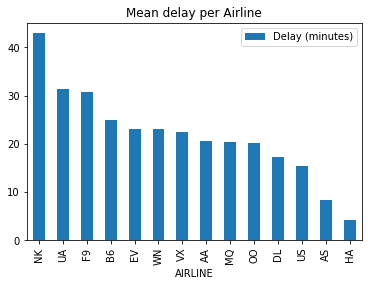

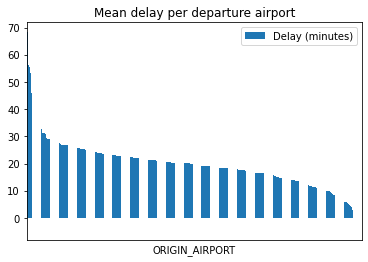

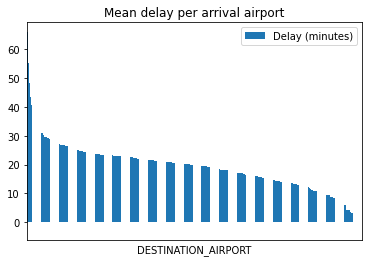

In [5]:
# Delay per airline

toPlot = df[['TOTAL_DELAY', 'AIRLINE']].groupby(['AIRLINE']).mean().sort_values('TOTAL_DELAY', ascending=False)
toPlot = toPlot.rename(columns={'TOTAL_DELAY': "Delay (minutes)"})
toPlot.plot.bar()
plt.title("Mean delay per Airline")

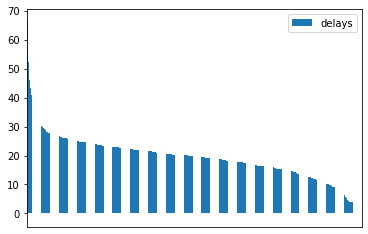

In [6]:
# Get the total delay per airport (irrespective of it being origin/arrival)

airport_codes = airports['IATA_CODE']
delays = []

for airport in airport_codes:
    delay = df[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'TOTAL_DELAY']].loc[
        (df['ORIGIN_AIRPORT'] == airport) | (df['DESTINATION_AIRPORT'] == airport)].mean(numeric_only=True, skipna=True)
    delays.append(delay.values[0])

# print(delayPerAirport)
d = {"Airports" : airport_codes, "delays": delays}
delayPerAirport = pd.DataFrame(data = d).dropna().sort_values('delays', ascending=False)
delayPerAirport.plot.bar()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

In [67]:
# From the plot above we see that there is a small percentage of airports with very high delay and a small percentage
# of airports with very small delay. We base our classification on this.
# There are six missing values. We put these airports in the middle class

# Set the quantile of delays that we concider high/low. If f.e. SIGNIFICANT = 0.05 is specified, we concider the upper
# 5% of delay times as large and the lower 5% of delay times as small. The middle 90% is concidered moderate.
SIGNIFICANT = 0.1

def classify_airport(row, q_lower, q_upper):
    if math.isnan(row['delays']):
        return "Moderate"
    
    if row['delays'] < q_lower:
        return "Low"
    elif row['delays'] > q_upper:
        return "High"
    else:
        return "Moderate"

airport_delay = pd.DataFrame({'airport' : airport_codes, 'delays' : delays}).sort_values('delays')
q_lower = airport_delay.quantile(SIGNIFICANT, interpolation = "lower", axis = 0)[0]
q_upper = airport_delay.quantile(1-SIGNIFICANT, interpolation = "lower", axis = 0)[0]
airport_delay['airport_class'] = airport_delay.apply(lambda row: classify_airport(row, q_lower, q_upper), axis = 1)

airport_delay.drop(columns=['delays'], inplace=True)

merged = pd.merge(df, airport_delay, how="inner", left_on = 'ORIGIN_AIRPORT', right_on = "airport", validate="m:1")
merged['ORIGIN_AIRPORT'] = merged['airport_class']
merged.drop(columns = ['airport', 'airport_class'], inplace=True)

merged = pd.merge(merged, airport_delay, how="inner", left_on = 'DESTINATION_AIRPORT', right_on = "airport", validate="m:1")
merged['DESTINATION_AIRPORT'] = merged['airport_class']
merged.drop(columns = ['airport', 'airport_class'], inplace=True)

merged.rename(columns = {'ORIGIN_AIRPORT' : 'ORIGIN_CLASS', 'DESTINATION_AIRPORT' : 'DESTINATION_CLASS'}, inplace=True)

merged

,DEPARTURE_MONTH,DEPARTURE_DAY,DEPARTURE_DOW,AIRLINE,ORIGIN_CLASS,DESTINATION_CLASS,SCHEDULED_TIME,DISTANCE,CANCELLED,TOTAL_DELAY,ELAPSED_TIME_SELF,TARGET_1,TARGET_2,TARGET_3
0,3,1,4,UA,Moderate,Moderate,96.0,455,0,1.0,96.0,1.0,1.0,1.0
1,3,1,4,OO,Moderate,Moderate,98.0,455,0,-4.0,98.0,-4.0,-4.0,-4.0
2,3,1,4,UA,Moderate,Moderate,98.0,455,0,12.0,98.0,12.0,12.0,12.0
3,3,1,4,OO,Moderate,Moderate,95.0,455,0,126.0,95.0,126.0,126.0,126.0
4,3,1,4,UA,Moderate,Moderate,98.0,455,0,18.0,98.0,18.0,18.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458623,7,27,5,AS,Moderate,Moderate,23.0,31,0,-18.0,23.0,-18.0,-18.0,-18.0
2458624,7,28,6,AS,Moderate,Moderate,23.0,31,0,37.0,23.0,37.0,37.0,37.0
2458625,7,29,0,AS,Moderate,Moderate,23.0,31,0,58.0,23.0,58.0,58.0,58.0
2458626,7,30,1,AS,Moderate,Moderate,23.0,31,0,10.0,23.0,10.0,10.0,10.0


In [68]:
# Save the data set
merged.to_csv("Data/modified_data_with_classes.csv", index = False)